# Part 1 Data Gathering


In [ ]:
# Install the required packages
! pip install beautifulsoup4
! pip install yfinance
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(Reading database ... 128152 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bs4 import BeautifulSoup as bs 
import requests
import yfinance as yf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report
import numpy as np
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

In [ ]:
#@title functions 
FEATURES_SIZE = 180 
LABELLING_SIZE = 90

def calculate_returns(x):
  return 100*(x.iloc[-1]['Close'] - x.iloc[0]['Open'])/x.iloc[0]['Open']

def get_features_labels_from_full_dataframe(df, start_train_features_day = 0, featutes_size=FEATURES_SIZE, labeling_size = LABELLING_SIZE):
  end_train_features_day = start_train_features_day + featutes_size
  start_train_labelling_day = end_train_features_day + 1 
  end_train_labelling_day = start_train_labelling_day + labeling_size

  print(f'start_date:{start_train_features_day} , end_ft_day: {end_train_features_day}\
        start_lbl_date:{start_train_labelling_day} , end_lbl_day: {end_train_labelling_day}')
  
  features_train_df = df[(df['t0'] >= start_train_features_day)&(df['t0'] < end_train_features_day)]
  labelling_train_df = df[(df['t0'] >= start_train_labelling_day)&(df['t0'] < end_train_labelling_day)]
  return features_train_df, labelling_train_df

def add_label_to_labelling_df(labelling_train_df):
  lbl_returns = labelling_train_df.groupby('stock').apply(lambda x: calculate_returns(x)).reset_index()
  lbl_returns.columns = ['stock', 'pct_price_movement']
  threshold = lbl_returns['pct_price_movement'].median()
  lbl_returns['label'] = lbl_returns['pct_price_movement']>threshold
  return lbl_returns.set_index('stock')

def calculate_featurs(features_train_df):
  features_df = features_train_df.copy()
  features_df['month_index'] = (features_df['t0'] / 30).astype(int)
  monthly_features_df = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()
  worst_monthly_return = monthly_features_df.groupby('stock').min().reset_index()
  best_monthly_return = monthly_features_df.groupby('stock').max().reset_index()
  ft_df = best_monthly_return[['stock',0]]
  ft_df['worst'] = worst_monthly_return[0]
  ft_df.columns = ['stock', 'best_month', 'worst_month']
  return ft_df.set_index('stock')


def add_actual(test_df,all_labelling_test_df):
  test_returns = all_labelling_test_df.groupby('stock').apply(lambda x:calculate_returns(x))
  label_threshold = test_returns.median()
  good_test = test_returns[test_returns > label_threshold].index
  test_df.loc[test_df['stock'].isin(good_test),'actual_y'] = 1
  test_df['actual_y'].fillna(0,inplace=True)
  test_df['actual_y'].value_counts()
  return test_df

def Get_Monthly(all_features_test_df):
  features_df2 = all_features_test_df.copy()
  features_df2['month_index'] = (features_df2['t0'] / 30).astype(int)
  return   features_df2.groupby(['stock','month_index']).apply(calculate_returns).reset_index() 


def Confusion_and_Report(df):
  true_positive = len(df[(df['predicted_y'] == df['actual_y'])&(df['predicted_y']==True)])
  true_negative = len(df[(df['predicted_y'] == df['actual_y'])&(df['predicted_y']==False)])
  false_positive = len(df[(df['predicted_y'] != df['actual_y'])&(df['predicted_y']==True)])
  false_negative = len(df[(df['predicted_y'] != df['actual_y'])&(df['predicted_y']==False)])
  print(
        f'''
        Train results:
          True positive: {true_positive},
          True negative: {true_negative},
          False positive: {false_positive},
          False negative: {false_negative}

          
        ''')
  matrix = confusion_matrix(df['actual_y'], df['predicted_y'])
  disp = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
  disp.plot(cmap=plt.cm.Blues)

  plt.show()

  report = classification_report(df['actual_y'], df['predicted_y'])
  print(report)

def Get_ROC(df):
  
  fpr, tpr, thresholds = roc_curve(df['actual_y'], df['predicted_y'])
  # Plot the ROC curve
  print(roc_auc_score(df['actual_y'], df['predicted_y']))
  plt.plot(fpr, tpr)
  # Add the luck line
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(['1st time period ','Random guess'])   
  plt.title("ROC Curve")
  plt.show()

#download online

In [ ]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [ ]:
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
all_stocks = [x.replace('\n','') for x in tickers] # remove the new line character

In [ ]:
all_df = pd.DataFrame()
start_date = '2018-07-01'
end_date = '2022-09-01'
fname_string = 'all_stocks_' + start_date + '_' + end_date + '.csv'


for tkr in all_stocks:
  single_stock_pd = yf.download(tickers=tkr, start=start_date, end=end_date,auto_adjust=True)
  single_stock_pd['stock'] = tkr
  all_df = all_df.append(single_stock_pd)


all_df = (
          all_df
          .reset_index()
          .assign(dt = lambda d:pd.to_datetime(d['Date']),
                  t0 = lambda d:(d['dt'] - d['dt'].min()).dt.days.astype(float))
          )

all_df.to_csv(fname_string)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Calculate Features & Target values for all stocks


In [ ]:
all_features_train_df,all_labelling_train_df = get_features_labels_from_full_dataframe(all_df)

start_date:0 , end_ft_day: 180        start_lbl_date:181 , end_lbl_day: 271


stock
A       21.163711
AAL     -0.758539
AAP      9.319021
AAPL    20.333468
ABBV   -10.940587
          ...    
YUM      9.225103
ZBH     24.167312
ZBRA    33.399114
ZION    12.829643
ZTS     18.293428
Length: 495, dtype: float64


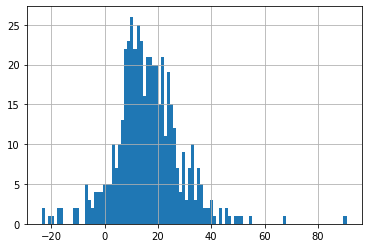

In [ ]:
# Calculating the train returns in the labelling 3 months
train_returns = all_labelling_train_df.groupby('stock').apply(lambda x: calculate_returns(x))
train_returns.hist(bins=100)
print(train_returns)

In [ ]:
# Splitting the stocks to good and bad stocks based on greater or less then the median return

threshold = train_returns.median()
good = train_returns[train_returns>threshold].index
bad = train_returns[train_returns<threshold].index

# Calculating features for the train features months

##From yigal

In [ ]:
#@title Creating a monthly df for calculations
features_df = all_features_train_df.copy()
labelling_df = all_labelling_train_df.copy()
features_df['month_index'] = (features_df['t0'] / 30).astype(int)
monthly_features_df = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()


In [ ]:
#@title Calculating each stock best and worst monthly return to be used as our features
worst_monthly_return = monthly_features_df.groupby('stock').min().reset_index()
best_monthly_return = monthly_features_df.groupby('stock').max().reset_index()
train_df = best_monthly_return[['stock',0]]
train_df['worst'] = worst_monthly_return[0]
train_df.columns = ['stock', 'best_month', 'worst_month']


##Our Features

In [ ]:
#@title all features

def indexReturn(df,features_df):
    sumOpen = features_df.groupby('stock')['Open'].first().sum()
    sumClose = features_df.groupby('stock')['Close'].last().sum()
    return (df
            .assign(IndexReturn = 100*(sumClose-sumOpen)/sumOpen)
            )
    
def total_yield(df,features_df):
    total_yield = (
                  features_df
                  .groupby('stock')
                  .apply(calculate_returns)
                  .reset_index()
                  [0]
                  )
    return df.assign(total_yield = total_yield.values)

def Revenue_To_Index(df):
    return (
            df
            .assign(ComparedToIndex = df['total_yield']-df['IndexReturn'])
            .drop('IndexReturn',axis = 1)
            )

def Add_Avg_Volumn(df,features_df):
  VolumeSeries = (
                features_df
                .assign(avg_Volume = features_df['Volume'].rolling(window=180).mean())
                .pipe(lambda d:d.groupby('stock')['avg_Volume'].mean())           
                )
  return (
          df
          .assign(avg_Volume = VolumeSeries.values)
          .pipe(lambda d:d.fillna({'avg_Volume':-999}))
          )
  

def Get_perc_of_profit(df,features_df):
  features_df['days_of_profit'] = features_df['Close'] > features_df['Open']
  count_profit_days = (
                      features_df
                      .query('days_of_profit>0')
                      .groupby('stock')
                      ['days_of_profit']
                      .count()
                      )
  count_days = (
                features_df
                .groupby('stock')
                ['t0']
                .count()
                )
  return df.assign(percDaysOfProfit = count_profit_days.div(count_days,fill_value=-999).values)


def Get_SMA(df,features_df):
  f =  (
      features_df
      .assign(sma10 = features_df["Close"].rolling(window=10).mean(),
           sma30 = features_df["Close"].rolling(window=30).mean(),
           sma50 = features_df["Close"].rolling(window=50).mean())
        )

  return df.assign(sma10 = f.groupby('stock')['sma10'].mean().values,
                   sma30 = f.groupby('stock')['sma30'].mean().values,
                   sma50 = f.groupby('stock')['sma50'].mean().values)
  
def Get_RSI(df,features_df):
  change = features_df["Close"].diff()
  change_up = change.copy()
  change_down = change.copy()
  change_up[change_up<0] = 0
  change_down[change_down>0] = 0
  avg_up = change_up.rolling(14).mean()
  avg_down = change_down.rolling(14).mean().abs()
  features_df=features_df.assign(rsi=( 100 * avg_up / (avg_up + avg_down)).values)
  return df.assign(RSI=features_df.groupby('stock')['rsi'].mean().values)

def Get_std_monthly(df,monthly_features_df):
  return (
          df
          .assign(std = monthly_features_df.groupby('stock')[0].std().values)
          .fillna({'std':0})
          )

def Get_Bollinger(df):
  return df.assign(bb_upper = df['sma30'] + (df['std'] * 2),
                   bb_lower = df['sma30'] - (df['std'] * 2)
                   )

def Get_Beta(df,features_df):
  f = features_df.assign(Beta = talib.BETA(features_df['High'], features_df['Low'], timeperiod=30))
  return (
          df
          .assign(Beta=f.groupby('stock')['Beta'].mean().values)
          .fillna({'Beta':-999})
          )
def Get_ATR(df,features_df):
  f = features_df.assign(ATR = talib.ATR(features_df['High'], features_df['Low'], features_df['Close'], timeperiod=14))
  return (
          df
          .assign(ATR=f.groupby('stock')['ATR'].mean().values)
          .fillna({'ATR':-999})
          )
def Get_adx(df,features_df):
  f = features_df.assign(adx = talib.ADX(features_df['High'], features_df['Low'], features_df['Close'], timeperiod=180))
  return (df
          .assign(adx = f.groupby('stock')['adx'].mean().values)
          .fillna({'adx':-999})
          )

In [ ]:
def Get_all_features(df,features_df,monthly_features_df):
    return (
            df
            .pipe(lambda d:indexReturn(d,features_df))
            .pipe(lambda d:total_yield(d,features_df))
            .pipe(lambda d:Revenue_To_Index(d))
            .pipe(lambda d:Add_Avg_Volumn(d,features_df))
            .pipe(lambda d:Get_perc_of_profit(d,features_df))
            .pipe(lambda d:Get_SMA(d,features_df))
            .pipe(lambda d:Get_RSI(d,features_df))
            .pipe(lambda d:Get_std_monthly(d,monthly_features_df))
            .pipe(lambda d:Get_Bollinger(d))
            .pipe(lambda d:Get_Beta(d,features_df))
            .pipe(lambda d:Get_ATR(d,features_df))
            .pipe(lambda d:Get_adx(d,features_df))
          )

In [ ]:
#@title Adding a binary target column for our classification based on the labelling
train_df = (
            Get_all_features(train_df,features_df,monthly_features_df)
            .assign(target = lambda d:np.where(d['stock'].isin(good),1,0))
            )
train_df['target'].value_counts()

1    247
0    245
Name: target, dtype: int64

# Training the model

In [ ]:
#@title Check for NA
train_df.loc[:, train_df.isna().any()]


""
0
1
2
3
4
...
487
488
489
490


In [ ]:
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(train_df.drop(['stock','target'],axis=1), train_df['target'])

RandomForestClassifier(max_depth=3, random_state=0)

#Final Task

##First Assignment

####1.1

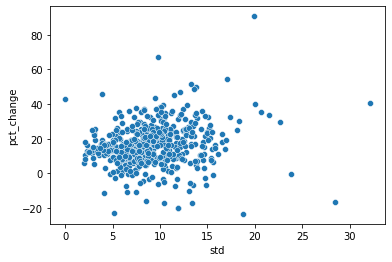

In [ ]:
feature_chosen = 'std'
reg_df = (
          train_df
          [['stock',feature_chosen]]
          .merge(train_returns.to_frame().reset_index(),on='stock')
          .set_index('stock')
          .rename(columns={0:'pct_change'})
          )
sns.scatterplot(x=feature_chosen, y='pct_change',data=reg_df)

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

correlation, pvalue = pearsonr(reg_df[feature_chosen], reg_df['pct_change'])

# Print the correlation
print(f"Correlation: {correlation}")

x = np.array(reg_df[feature_chosen]).reshape(-1,1)
y = np.array(reg_df['pct_change'])

reg = LinearRegression().fit(x, y)
print(f"Intercept: {reg.intercept_} \
       \nCoefficient: {reg.coef_[0]}")

Correlation: 0.1663926174215306
Intercept: 11.412172078779047        
Coefficient: 0.5249952198830796


###1.2
Creating a new label system(instead of pct_returns)

In [ ]:
threshold = reg_df[feature_chosen].median()

good = reg_df.query(f'{feature_chosen} > @threshold').index
bad = reg_df.query(f'{feature_chosen} < @threshold').index

new_train = (
            train_df
            .drop('target',axis=1)
            .assign(target=np.where(train_df['stock'].isin(good),1,0))
            )

In [ ]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(new_train.drop(['stock','target'],axis=1), new_train['target'])

RandomForestClassifier(max_depth=3, random_state=0)

In [ ]:
all_features_test_df,all_labelling_test_df = get_features_labels_from_full_dataframe(all_df,start_train_features_day = 270)
features_df2 = all_features_test_df.copy()
monthly_features_df2 = Get_Monthly(all_features_test_df)
new_test = calculate_featurs(all_features_test_df).reset_index()
new_test = Get_all_features(new_test, features_df2, monthly_features_df2)

start_date:270 , end_ft_day: 450        start_lbl_date:451 , end_lbl_day: 541


####Statistical Difference

There is a significant difference in the distribution of best_month between the True and False groups (p-value = 0.000)



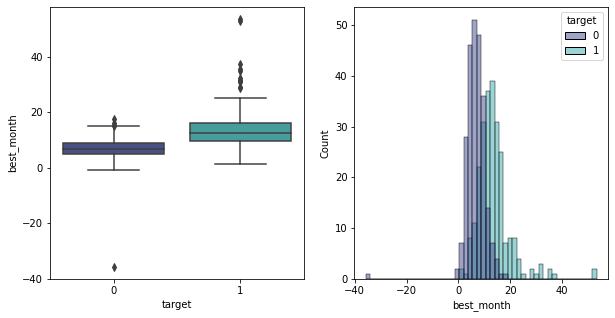

There is a significant difference in the distribution of worst_month between the True and False groups (p-value = 0.000)



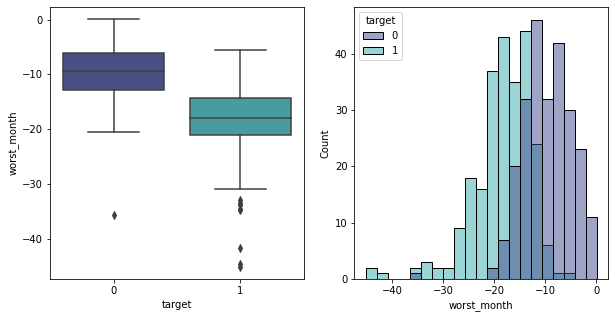

There is a significant difference in the distribution of total_yield between the True and False groups (p-value = 0.000)



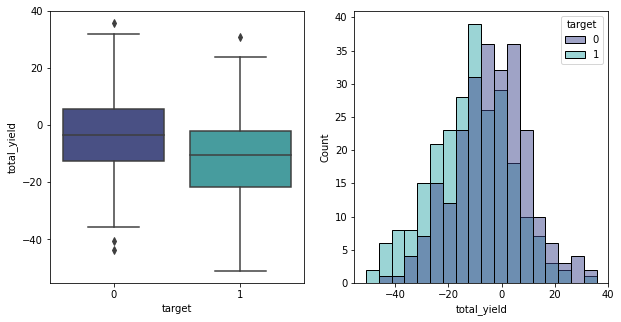

There is a significant difference in the distribution of ComparedToIndex between the True and False groups (p-value = 0.000)



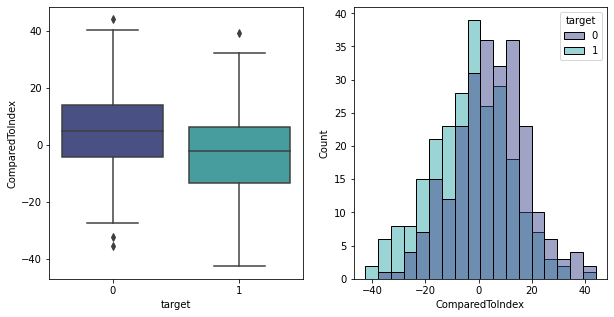

There is no significant difference in the distribution of avg_Volume between the True and False groups (p-value = 0.085)



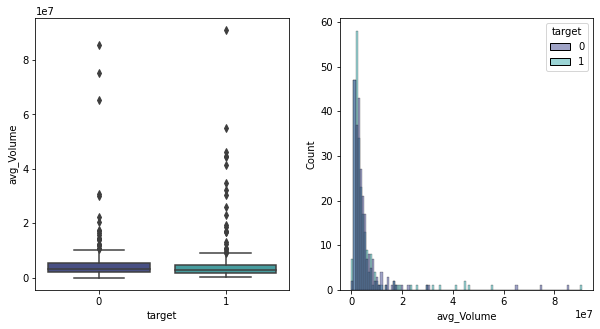

There is a significant difference in the distribution of percDaysOfProfit between the True and False groups (p-value = 0.002)



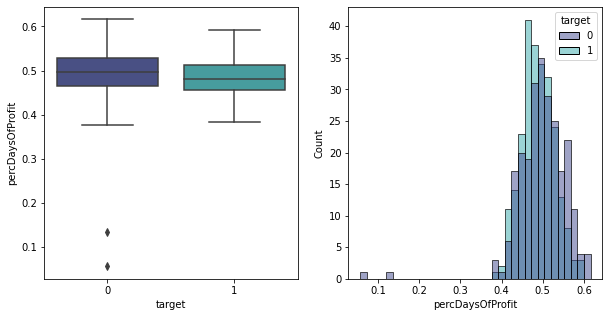

There is no significant difference in the distribution of sma10 between the True and False groups (p-value = 0.426)



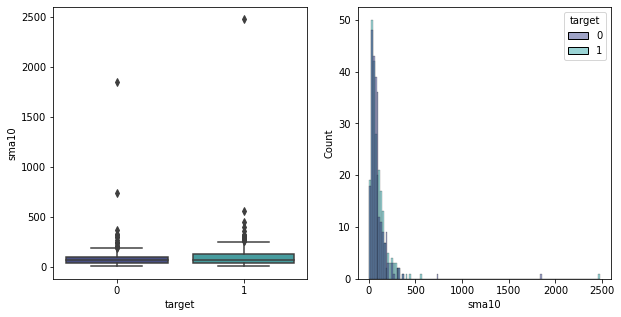

There is no significant difference in the distribution of sma30 between the True and False groups (p-value = 0.351)



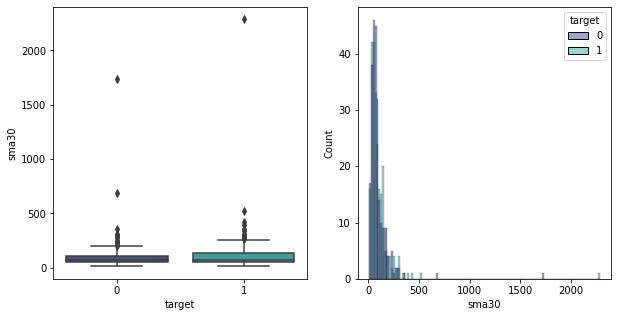

There is no significant difference in the distribution of sma50 between the True and False groups (p-value = 0.251)



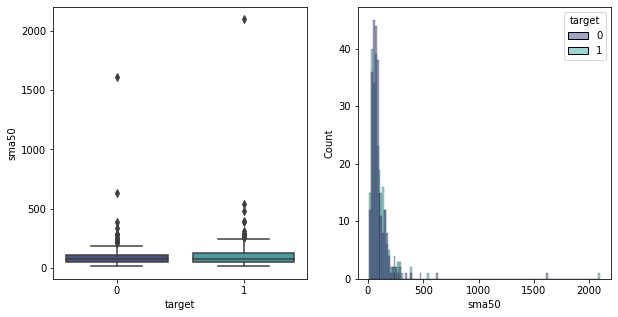

There is a significant difference in the distribution of RSI between the True and False groups (p-value = 0.004)



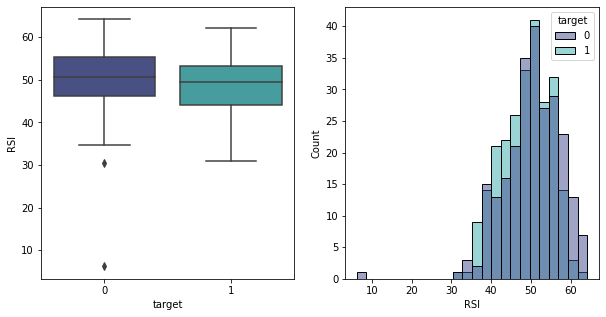

There is a significant difference in the distribution of bb_upper between the True and False groups (p-value = 0.000)



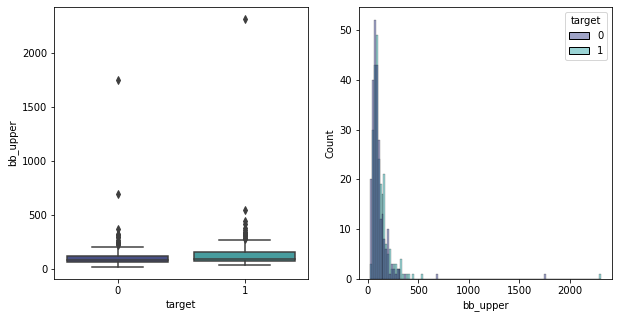

There is no significant difference in the distribution of bb_lower between the True and False groups (p-value = 0.072)



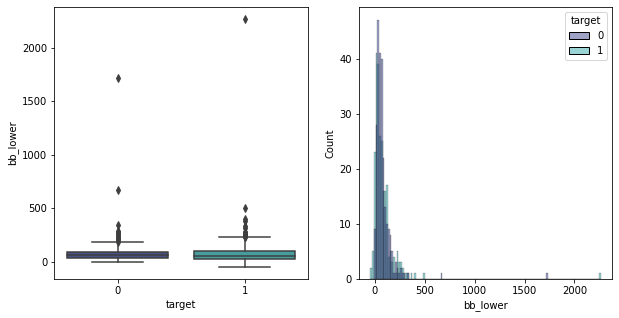

There is no significant difference in the distribution of Beta between the True and False groups (p-value = 0.827)



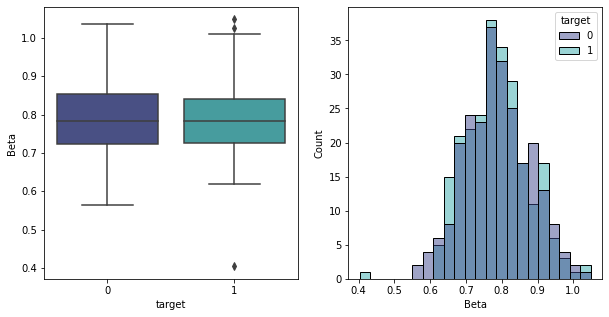

There is a significant difference in the distribution of ATR between the True and False groups (p-value = 0.000)



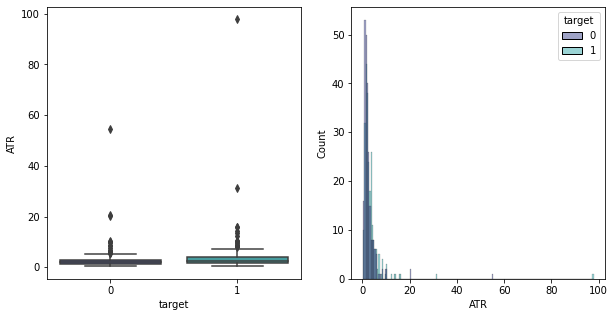

There is no significant difference in the distribution of adx between the True and False groups (p-value = 0.962)



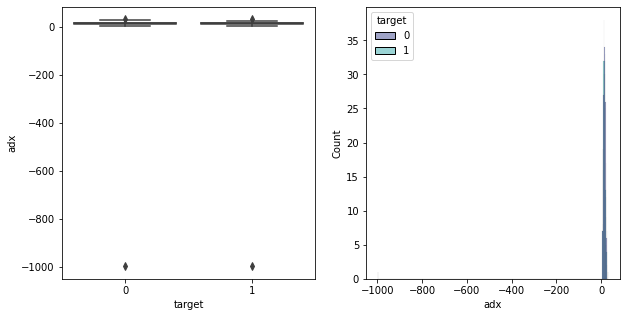

In [ ]:
good_stocks = new_train[new_train['target'] == True]
bad_stocks = new_train[new_train['target'] == False]

from scipy.stats import mannwhitneyu
for feature in new_train.drop(['stock',feature_chosen,'target'],axis=1).columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    sns.boxplot(x='target', y=feature, data=new_train, palette='mako',ax=ax1)
    sns.histplot(x=feature, data=new_train,palette='mako',hue='target',ax=ax2)

    statistic, pvalue = mannwhitneyu(good_stocks[feature], bad_stocks[feature])
    if pvalue < 0.05:
        print(f'\033[1mThere is a significant difference in the distribution of {feature} between the True and False groups (p-value = {pvalue:.3f})\033[0m')
    else:
        print(f'\033[1mThere is no significant difference in the distribution of {feature} between the True and False groups (p-value = {pvalue:.3f})\033[0m')
    print()

    plt.show()
    

In [ ]:
stats_good = (
              good_stocks
              .describe()
              .T
              .assign(skew = good_stocks.skew().tolist(),
                       kurt = good_stocks.kurtosis().tolist())
              .T
              )
stats_bad = (
              bad_stocks
              .describe()
              .T
              .assign(skew = bad_stocks.skew().tolist(),
                       kurt = bad_stocks.kurtosis().tolist())
              .T
              )

display(stats_good)
display(stats_bad)

,best_month,worst_month,total_yield,ComparedToIndex,avg_Volume,percDaysOfProfit,sma10,sma30,sma50,RSI,std,bb_upper,bb_lower,Beta,ATR,adx,target
count,246.000000,246.000000,246.000000,246.000000,2.460000e+02,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.0
mean,13.687687,-18.472048,-11.767191,-3.510241,5.327781e+06,0.483122,108.665386,108.745727,108.805653,48.620912,12.148522,133.042770,84.448684,0.786300,3.685026,11.372631,1.0
std,6.766068,5.757157,14.841477,14.841477,9.419649e+06,0.039611,172.195053,159.398049,148.217437,6.212578,3.107711,158.979030,160.057511,0.089440,6.762633,64.839311,0.0
min,1.112749,-45.096122,-50.898155,-42.641204,3.495257e+05,0.384000,6.973777,10.996061,13.879911,30.875645,8.888899,34.694049,-43.440962,0.403815,0.447716,-999.000000,1.0
25%,9.430468,-21.089441,-21.605372,-13.348421,1.712501e+06,0.456000,43.620889,48.141855,52.374417,44.021949,10.098875,75.301079,22.989845,0.724542,1.552212,12.177514,1.0
50%,12.600804,-17.893845,-10.574506,-2.317555,2.721312e+06,0.480000,71.110542,73.407432,78.259535,49.515926,11.271043,97.810179,51.694371,0.782245,2.424696,14.975068,1.0
75%,15.916157,-14.323805,-1.954957,6.301994,4.641807e+06,0.512000,129.437950,130.491645,129.095262,53.293332,13.429298,153.867621,105.218759,0.841005,3.953616,18.149102,1.0
max,53.404864,-5.503907,30.946239,39.203190,9.087958e+07,0.592000,2477.932736,2285.005408,2097.781820,62.277492,32.130005,2306.396144,2263.614672,1.048238,97.793380,31.934611,1.0
skew,2.347080,-1.412933,-0.102010,-0.102010,5.239098e+00,0.190899,10.905966,10.667953,10.212162,-0.299293,2.509299,10.707911,10.578431,-0.022551,11.456287,-15.569361,0.0
kurt,9.660260,3.893024,-0.061819,-0.061819,3.466932e+01,-0.203425,147.297572,142.731889,133.286836,-0.627640,10.262503,143.481217,141.124667,0.733272,155.120344,243.591299,0.0


,best_month,worst_month,total_yield,ComparedToIndex,avg_Volume,percDaysOfProfit,sma10,sma30,sma50,RSI,std,bb_upper,bb_lower,Beta,ATR,adx,target
count,246.000000,246.000000,246.000000,246.000000,2.460000e+02,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.0
mean,6.803419,-9.666655,-4.027929,4.229022,5.286156e+06,0.493518,96.725328,96.786889,96.782366,50.266468,6.276076,109.339041,84.234737,0.788292,2.824793,11.352075,0.0
std,4.142886,4.691953,13.865699,13.865699,8.933476e+06,0.059394,134.728288,125.532600,117.476352,7.196028,1.849222,125.857972,125.315582,0.090728,4.091269,64.848817,0.0
min,-35.681820,-35.681820,-43.875399,-35.618448,-9.990000e+02,0.056000,9.676817,13.011460,12.990210,6.209353,0.000000,23.823633,-2.084092,0.563835,0.303436,-999.000000,0.0
25%,4.874897,-12.903153,-12.667127,-4.410176,1.864071e+06,0.464000,44.983884,49.046520,52.882261,46.251575,5.038635,61.498910,36.139547,0.723459,1.346589,11.821135,0.0
50%,6.708873,-9.454481,-3.558029,4.698922,3.146631e+06,0.496000,71.980558,73.884079,74.076817,50.767306,6.686222,86.449289,60.996306,0.782995,2.028957,15.018912,0.0
75%,8.906800,-6.177184,5.828578,14.085529,5.250518e+06,0.528000,105.091116,109.074253,108.525835,55.260566,7.706270,124.074125,95.386144,0.853049,2.983120,18.726280,0.0
max,17.576911,0.028194,35.679781,43.936732,8.564579e+07,0.616000,1852.319438,1733.245820,1611.587817,64.188848,8.885942,1745.240398,1721.251242,1.035666,54.713205,31.731795,0.0
skew,-4.193270,-0.630349,-0.050561,-0.050561,6.476622e+00,-2.446095,9.679007,9.657345,9.374449,-1.088267,-0.684731,9.573440,9.716394,0.100729,9.174700,-15.561517,0.0
kurt,44.320345,2.698183,0.137232,0.137232,4.923455e+01,15.963621,120.027813,120.030519,114.775596,4.808992,-0.305040,118.586010,121.067337,-0.267340,108.347534,243.426673,0.0


#### Testing the model


In [ ]:
new_test['predicted_y'] = clf.predict(new_test.drop('stock',axis=1))

In [ ]:
#correct for std feature, need to make sure it good for others

labelling_df['month_index'] = (labelling_df['t0'] / 30).astype(int)
label_months = labelling_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()

test_returns = label_months.groupby('stock')[0].std()
label_threshold = test_returns.median()

good_test = test_returns[test_returns > label_threshold].index

new_test = (
            new_test
            .assign(actual_y=np.where(new_test['stock'].isin(good_test),1,0))
            )


        Train results:
          True positive: 109,
          True negative: 205,
          False positive: 44,
          False negative: 138

          
        


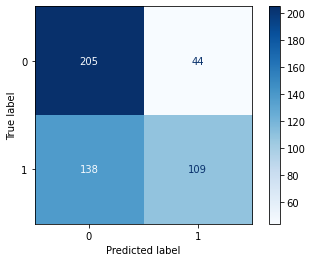

              precision    recall  f1-score   support

           0       0.60      0.82      0.69       249
           1       0.71      0.44      0.55       247

    accuracy                           0.63       496
   macro avg       0.66      0.63      0.62       496
weighted avg       0.65      0.63      0.62       496

0.6322943596247338


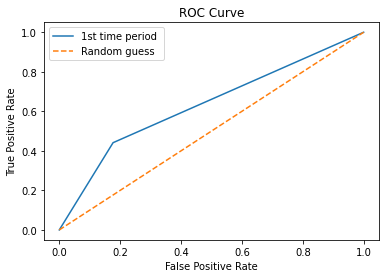

In [ ]:
Confusion_and_Report(new_test)
Get_ROC(new_test)

###1.3

In [ ]:
predicted = reg.predict(np.array(reg_df[feature_chosen]).reshape(-1,1))

In [ ]:
df_using_pct_reg = (
                    new_train
                    .drop('target',axis=1)
                    .assign(pct_change_reg=predicted.tolist())
                    )

threshold = df_using_pct_reg['pct_change_reg'].median()

good = df_using_pct_reg.query('pct_change_reg > @threshold').index
bad = df_using_pct_reg.query('pct_change_reg < @threshold').index

df_using_pct_reg = df_using_pct_reg.assign(target=np.where(df_using_pct_reg['pct_change_reg']>threshold,1,0))

Now we will do the stats analysis again

There is a significant difference in the distribution of best_month between the True and False groups (p-value = 0.000)



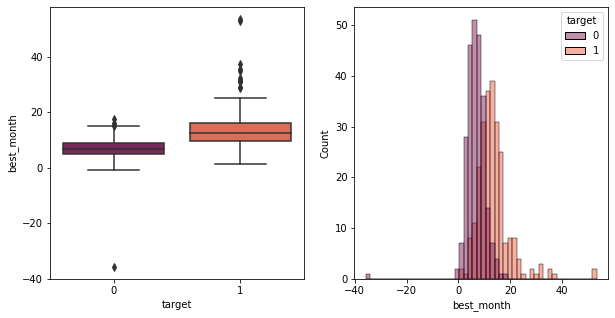

There is a significant difference in the distribution of worst_month between the True and False groups (p-value = 0.000)



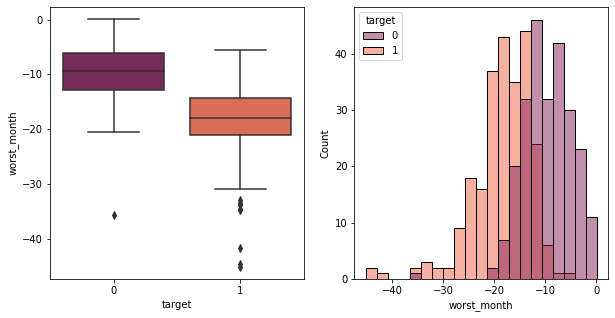

There is a significant difference in the distribution of total_yield between the True and False groups (p-value = 0.000)



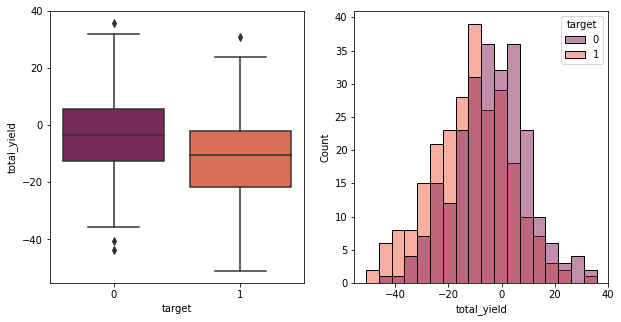

There is a significant difference in the distribution of ComparedToIndex between the True and False groups (p-value = 0.000)



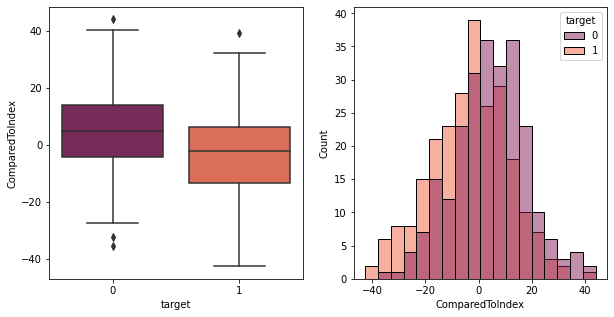

There is no significant difference in the distribution of avg_Volume between the True and False groups (p-value = 0.085)



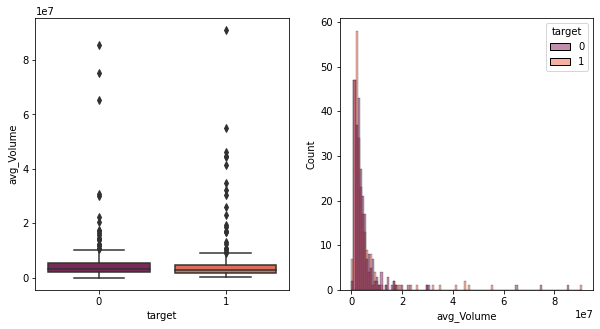

There is a significant difference in the distribution of percDaysOfProfit between the True and False groups (p-value = 0.002)



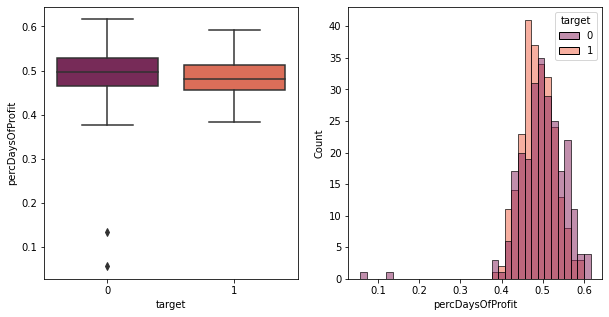

There is no significant difference in the distribution of sma10 between the True and False groups (p-value = 0.426)



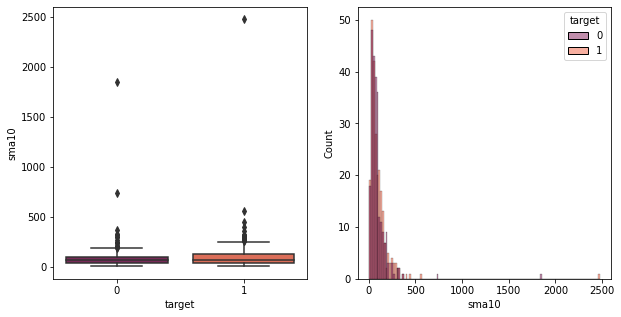

There is no significant difference in the distribution of sma30 between the True and False groups (p-value = 0.351)



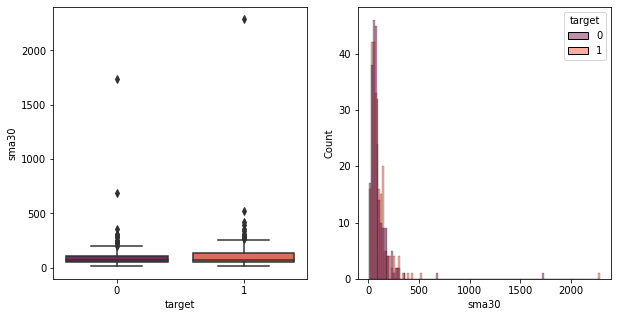

There is no significant difference in the distribution of sma50 between the True and False groups (p-value = 0.251)



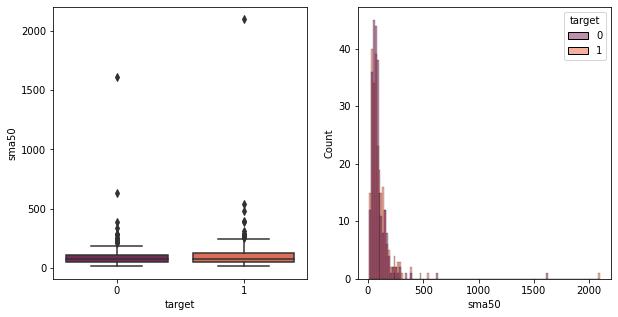

There is a significant difference in the distribution of RSI between the True and False groups (p-value = 0.004)



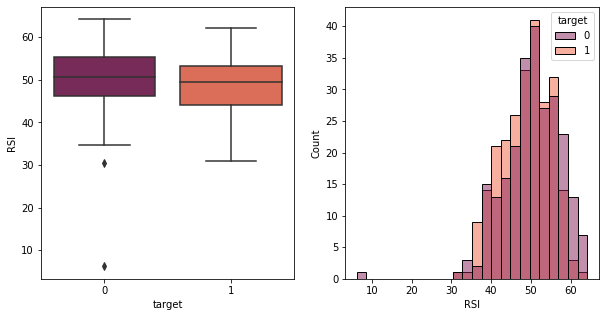

There is a significant difference in the distribution of std between the True and False groups (p-value = 0.000)



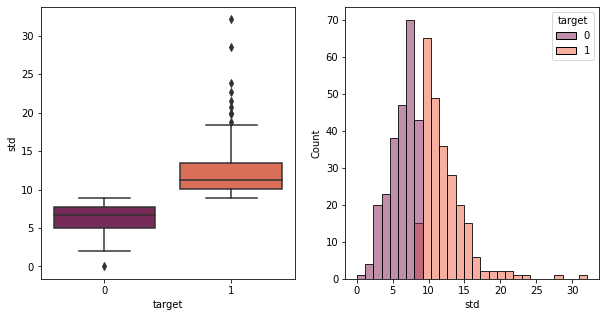

There is a significant difference in the distribution of bb_upper between the True and False groups (p-value = 0.000)



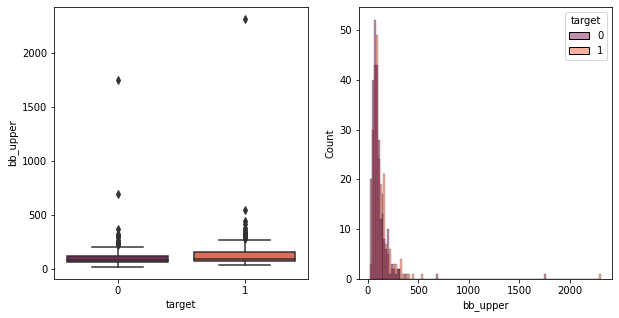

There is no significant difference in the distribution of bb_lower between the True and False groups (p-value = 0.072)



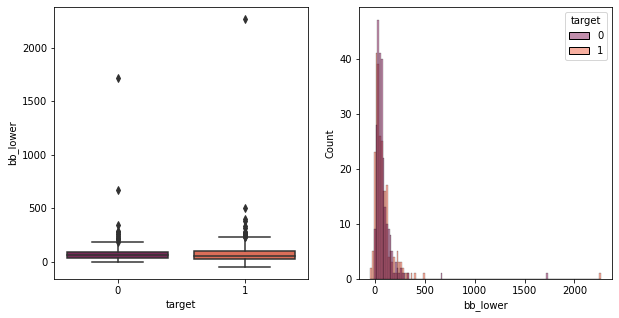

There is no significant difference in the distribution of Beta between the True and False groups (p-value = 0.827)



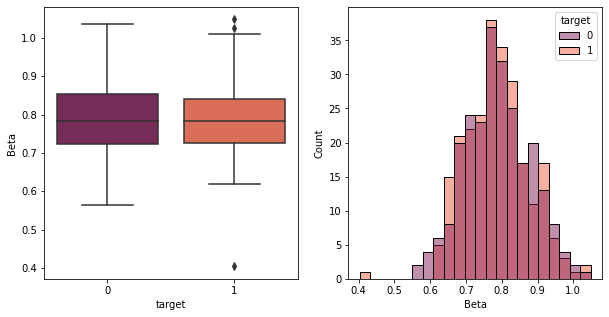

There is a significant difference in the distribution of ATR between the True and False groups (p-value = 0.000)



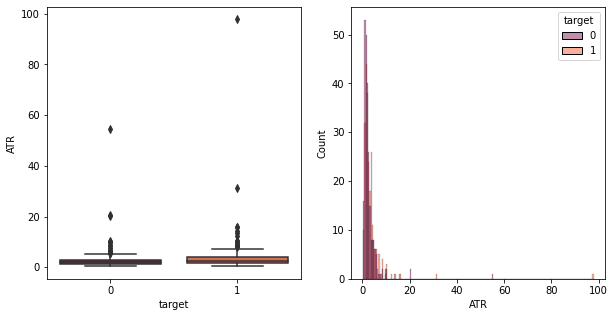

There is no significant difference in the distribution of adx between the True and False groups (p-value = 0.962)



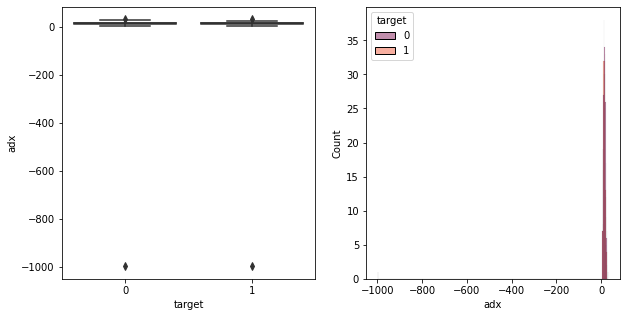

In [ ]:
good_stocks = df_using_pct_reg[df_using_pct_reg['target'] == True]
bad_stocks = df_using_pct_reg[df_using_pct_reg['target'] == False]

from scipy.stats import mannwhitneyu
for feature in df_using_pct_reg.drop(['stock','pct_change_reg','target'],axis=1).columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    sns.boxplot(x='target', y=feature, data=df_using_pct_reg, palette='rocket',ax=ax1)
    sns.histplot(x=feature, data=df_using_pct_reg,palette='rocket',hue='target',ax=ax2)

    statistic, pvalue = mannwhitneyu(good_stocks[feature], bad_stocks[feature])
    if pvalue < 0.05:
        print(f'\033[1mThere is a significant difference in the distribution of {feature} between the True and False groups (p-value = {pvalue:.3f})\033[0m')
    else:
        print(f'\033[1mThere is no significant difference in the distribution of {feature} between the True and False groups (p-value = {pvalue:.3f})\033[0m')
    print()

    plt.show()
    

In [ ]:
stats_good = (
              good_stocks
              .describe()
              .T
              .assign(skew = good_stocks.skew().tolist(),
                       kurt = good_stocks.kurtosis().tolist())
              .T
              )
stats_bad = (
              bad_stocks
             .describe()
              .T
              .assign(skew = bad_stocks.skew().tolist(),
                       kurt = bad_stocks.kurtosis().tolist())
              .T
              )

display(stats_good)
display(stats_bad)

,best_month,worst_month,total_yield,ComparedToIndex,avg_Volume,percDaysOfProfit,sma10,sma30,sma50,RSI,std,bb_upper,bb_lower,Beta,ATR,adx,pct_change_reg,target
count,246.000000,246.000000,246.000000,246.000000,2.460000e+02,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.0
mean,13.687687,-18.472048,-11.767191,-3.510241,5.327781e+06,0.483122,108.665386,108.745727,108.805653,48.620912,12.148522,133.042770,84.448684,0.786300,3.685026,11.372631,17.790088,1.0
std,6.766068,5.757157,14.841477,14.841477,9.419649e+06,0.039611,172.195053,159.398049,148.217437,6.212578,3.107711,158.979030,160.057511,0.089440,6.762633,64.839311,1.631534,0.0
min,1.112749,-45.096122,-50.898155,-42.641204,3.495257e+05,0.384000,6.973777,10.996061,13.879911,30.875645,8.888899,34.694049,-43.440962,0.403815,0.447716,-999.000000,16.078802,1.0
25%,9.430468,-21.089441,-21.605372,-13.348421,1.712501e+06,0.456000,43.620889,48.141855,52.374417,44.021949,10.098875,75.301079,22.989845,0.724542,1.552212,12.177514,16.714033,1.0
50%,12.600804,-17.893845,-10.574506,-2.317555,2.721312e+06,0.480000,71.110542,73.407432,78.259535,49.515926,11.271043,97.810179,51.694371,0.782245,2.424696,14.975068,17.329416,1.0
75%,15.916157,-14.323805,-1.954957,6.301994,4.641807e+06,0.512000,129.437950,130.491645,129.095262,53.293332,13.429298,153.867621,105.218759,0.841005,3.953616,18.149102,18.462489,1.0
max,53.404864,-5.503907,30.946239,39.203190,9.087958e+07,0.592000,2477.932736,2285.005408,2097.781820,62.277492,32.130005,2306.396144,2263.614672,1.048238,97.793380,31.934611,28.280271,1.0
skew,2.347080,-1.412933,-0.102010,-0.102010,5.239098e+00,0.190899,10.905966,10.667953,10.212162,-0.299293,2.509299,10.707911,10.578431,-0.022551,11.456287,-15.569361,2.509299,0.0
kurt,9.660260,3.893024,-0.061819,-0.061819,3.466932e+01,-0.203425,147.297572,142.731889,133.286836,-0.627640,10.262503,143.481217,141.124667,0.733272,155.120344,243.591299,10.262503,0.0


,best_month,worst_month,total_yield,ComparedToIndex,avg_Volume,percDaysOfProfit,sma10,sma30,sma50,RSI,std,bb_upper,bb_lower,Beta,ATR,adx,pct_change_reg,target
count,246.000000,246.000000,246.000000,246.000000,2.460000e+02,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.0
mean,6.803419,-9.666655,-4.027929,4.229022,5.286156e+06,0.493518,96.725328,96.786889,96.782366,50.266468,6.276076,109.339041,84.234737,0.788292,2.824793,11.352075,14.707082,0.0
std,4.142886,4.691953,13.865699,13.865699,8.933476e+06,0.059394,134.728288,125.532600,117.476352,7.196028,1.849222,125.857972,125.315582,0.090728,4.091269,64.848817,0.970833,0.0
min,-35.681820,-35.681820,-43.875399,-35.618448,-9.990000e+02,0.056000,9.676817,13.011460,12.990210,6.209353,0.000000,23.823633,-2.084092,0.563835,0.303436,-999.000000,11.412172,0.0
25%,4.874897,-12.903153,-12.667127,-4.410176,1.864071e+06,0.464000,44.983884,49.046520,52.882261,46.251575,5.038635,61.498910,36.139547,0.723459,1.346589,11.821135,14.057431,0.0
50%,6.708873,-9.454481,-3.558029,4.698922,3.146631e+06,0.496000,71.980558,73.884079,74.076817,50.767306,6.686222,86.449289,60.996306,0.782995,2.028957,15.018912,14.922407,0.0
75%,8.906800,-6.177184,5.828578,14.085529,5.250518e+06,0.528000,105.091116,109.074253,108.525835,55.260566,7.706270,124.074125,95.386144,0.853049,2.983120,18.726280,15.457927,0.0
max,17.576911,0.028194,35.679781,43.936732,8.564579e+07,0.616000,1852.319438,1733.245820,1611.587817,64.188848,8.885942,1745.240398,1721.251242,1.035666,54.713205,31.731795,16.077249,0.0
skew,-4.193270,-0.630349,-0.050561,-0.050561,6.476622e+00,-2.446095,9.679007,9.657345,9.374449,-1.088267,-0.684731,9.573440,9.716394,0.100729,9.174700,-15.561517,-0.684731,0.0
kurt,44.320345,2.698183,0.137232,0.137232,4.923455e+01,15.963621,120.027813,120.030519,114.775596,4.808992,-0.305040,118.586010,121.067337,-0.267340,108.347534,243.426673,-0.305040,0.0


####Testing using the regression values

In [ ]:
threshold = df_using_pct_reg['pct_change_reg'].median()

good = (
        df_using_pct_reg
        .set_index('stock')
        .query('pct_change_reg > @threshold')
        .index)

bad = (
        df_using_pct_reg
        .set_index('stock')
        .query('pct_change_reg < @threshold')
        .index)

train_reg = (
            df_using_pct_reg
            .assign(target=np.where(df_using_pct_reg['stock'].isin(good),1,0))
            )

In [ ]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(train_reg.drop(['stock','pct_change_reg','target'],axis=1), train_reg['target'])
reg_test = new_test.drop(['predicted_y','actual_y'],axis=1).copy()
reg_test['predicted_y'] = clf.predict(reg_test.drop('stock',axis=1))

In [ ]:
label_df = (
            add_label_to_labelling_df(labelling_df)
            .reset_index()
            .drop('pct_price_movement',axis=1)
            )

In [ ]:
reg_test = pd.merge(reg_test, label_df, on = 'stock',how='inner').rename(columns={'label':'actual_y'})


        Train results:
          True positive: 72,
          True negative: 167,
          False positive: 81,
          False negative: 175

          
        


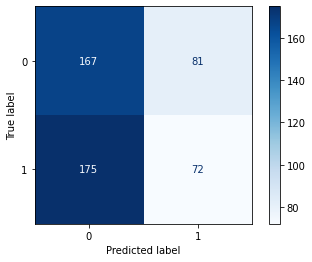

              precision    recall  f1-score   support

       False       0.49      0.67      0.57       248
        True       0.47      0.29      0.36       247

    accuracy                           0.48       495
   macro avg       0.48      0.48      0.46       495
weighted avg       0.48      0.48      0.46       495

0.4824425362413478


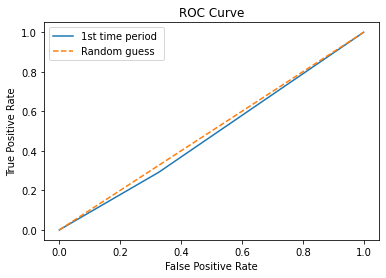

In [ ]:
Confusion_and_Report(reg_test)
Get_ROC(reg_test)

###1.4

At first we tried to pick a feature which will enable us to find a plane where the two groups(good stocks/bad stocks) are easily seperated by a linear line, our closest feature to do so was the std of monthly revenue, even then it wasnt a good enough seperator for a couple of reasons, firstly there isnt any one 'simple' feature that can do so in the stocks domain due to its complexity nature, secondly we used a linear regressor which is limited in its nature, even if we found a good enough feature that was able transform the plane so its easy to seperate the two groups it doesnt mean that a linear line could do so(refer to example A).

linear regression by itself isnt a strong enough model for predicting good or bad stocks but it can be used as a tool for feature creations of trend based features

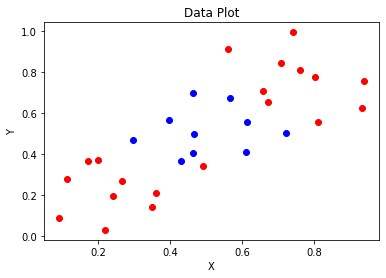

In [ ]:
#@title example A
np.random.seed(123)
low_data = np.random.rand(10, 2) * 0.5
mid_data = np.random.rand(10, 2) * 0.5 + 0.25
high_data = np.random.rand(10, 2) * 0.5 + 0.5

# Create the plot and scatter the data
fig, ax = plt.subplots()
ax.scatter(low_data[:, 0], low_data[:, 1], color='red')
ax.scatter(mid_data[:, 0], mid_data[:, 1], color='blue')
ax.scatter(high_data[:, 0], high_data[:, 1], color='red')

# Add labels and titles
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data Plot')

# Show the plot
plt.show()


So to sum up we tried to predict the stocks that will have high performance in the next 3 months. obviously we saw that the linear regression not predicting well by herself , i mean that the value of our feature not predicting well by linear regression the value of the change. but it can indicate a trend, so when we chose threshold we saw that the feature values can predict not bad in general which stocks are better.

##Second Assignment

####2.1

the training df was done in the first part of this notebook has it was used for previous assignment

###2.2 - Testing 12 times



test iteration = 1
start_date:270 , end_ft_day: 450        start_lbl_date:451 , end_lbl_day: 541

        Train results:
          True positive: 100,
          True negative: 195,
          False positive: 53,
          False negative: 148

          
        


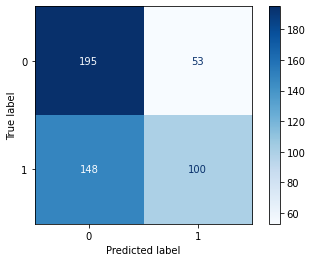

              precision    recall  f1-score   support

         0.0       0.57      0.79      0.66       248
         1.0       0.65      0.40      0.50       248

    accuracy                           0.59       496
   macro avg       0.61      0.59      0.58       496
weighted avg       0.61      0.59      0.58       496

test iteration = 2
start_date:300 , end_ft_day: 480        start_lbl_date:481 , end_lbl_day: 571

        Train results:
          True positive: 78,
          True negative: 180,
          False positive: 68,
          False negative: 170

          
        


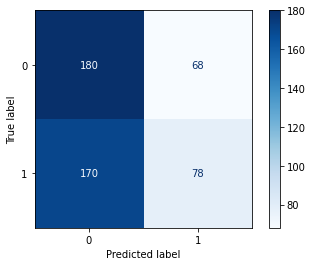

              precision    recall  f1-score   support

         0.0       0.51      0.73      0.60       248
         1.0       0.53      0.31      0.40       248

    accuracy                           0.52       496
   macro avg       0.52      0.52      0.50       496
weighted avg       0.52      0.52      0.50       496

test iteration = 3
start_date:330 , end_ft_day: 510        start_lbl_date:511 , end_lbl_day: 601

        Train results:
          True positive: 48,
          True negative: 173,
          False positive: 75,
          False negative: 200

          
        


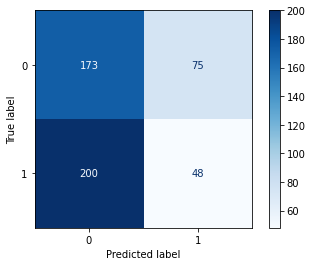

              precision    recall  f1-score   support

         0.0       0.46      0.70      0.56       248
         1.0       0.39      0.19      0.26       248

    accuracy                           0.45       496
   macro avg       0.43      0.45      0.41       496
weighted avg       0.43      0.45      0.41       496

test iteration = 4
start_date:360 , end_ft_day: 540        start_lbl_date:541 , end_lbl_day: 631

        Train results:
          True positive: 42,
          True negative: 167,
          False positive: 82,
          False negative: 205

          
        


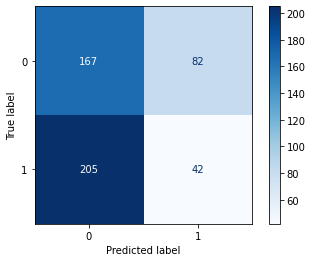

              precision    recall  f1-score   support

         0.0       0.45      0.67      0.54       249
         1.0       0.34      0.17      0.23       247

    accuracy                           0.42       496
   macro avg       0.39      0.42      0.38       496
weighted avg       0.39      0.42      0.38       496

test iteration = 5
start_date:390 , end_ft_day: 570        start_lbl_date:571 , end_lbl_day: 661

        Train results:
          True positive: 34,
          True negative: 158,
          False positive: 91,
          False negative: 213

          
        


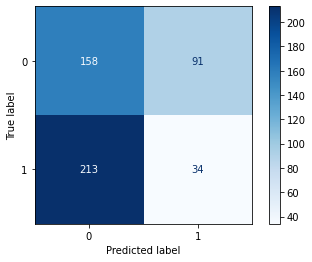

              precision    recall  f1-score   support

         0.0       0.43      0.63      0.51       249
         1.0       0.27      0.14      0.18       247

    accuracy                           0.39       496
   macro avg       0.35      0.39      0.35       496
weighted avg       0.35      0.39      0.35       496

test iteration = 6
start_date:420 , end_ft_day: 600        start_lbl_date:601 , end_lbl_day: 691

        Train results:
          True positive: 37,
          True negative: 211,
          False positive: 38,
          False negative: 210

          
        


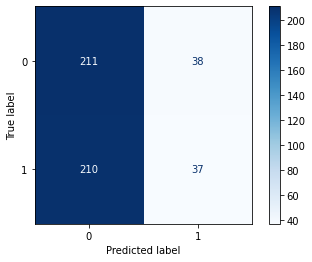

              precision    recall  f1-score   support

         0.0       0.50      0.85      0.63       249
         1.0       0.49      0.15      0.23       247

    accuracy                           0.50       496
   macro avg       0.50      0.50      0.43       496
weighted avg       0.50      0.50      0.43       496

test iteration = 7
start_date:450 , end_ft_day: 630        start_lbl_date:631 , end_lbl_day: 721

        Train results:
          True positive: 243,
          True negative: 33,
          False positive: 216,
          False negative: 6

          
        


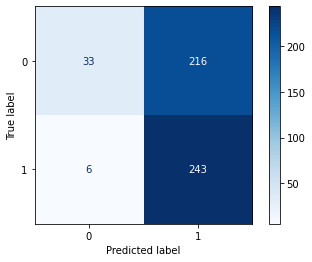

              precision    recall  f1-score   support

         0.0       0.85      0.13      0.23       249
         1.0       0.53      0.98      0.69       249

    accuracy                           0.55       498
   macro avg       0.69      0.55      0.46       498
weighted avg       0.69      0.55      0.46       498

test iteration = 8
start_date:480 , end_ft_day: 660        start_lbl_date:661 , end_lbl_day: 751

        Train results:
          True positive: 243,
          True negative: 11,
          False positive: 238,
          False negative: 6

          
        


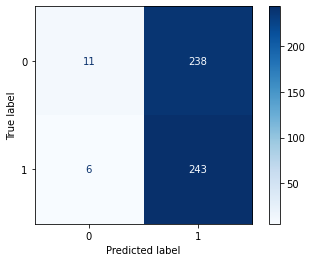

              precision    recall  f1-score   support

         0.0       0.65      0.04      0.08       249
         1.0       0.51      0.98      0.67       249

    accuracy                           0.51       498
   macro avg       0.58      0.51      0.37       498
weighted avg       0.58      0.51      0.37       498

test iteration = 9
start_date:510 , end_ft_day: 690        start_lbl_date:691 , end_lbl_day: 781

        Train results:
          True positive: 241,
          True negative: 10,
          False positive: 239,
          False negative: 8

          
        


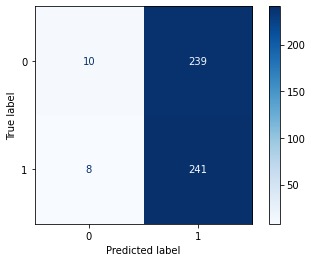

              precision    recall  f1-score   support

         0.0       0.56      0.04      0.07       249
         1.0       0.50      0.97      0.66       249

    accuracy                           0.50       498
   macro avg       0.53      0.50      0.37       498
weighted avg       0.53      0.50      0.37       498

test iteration = 10
start_date:540 , end_ft_day: 720        start_lbl_date:721 , end_lbl_day: 811

        Train results:
          True positive: 239,
          True negative: 8,
          False positive: 241,
          False negative: 10

          
        


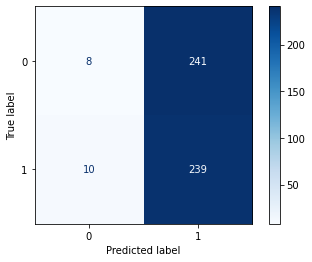

              precision    recall  f1-score   support

         0.0       0.44      0.03      0.06       249
         1.0       0.50      0.96      0.66       249

    accuracy                           0.50       498
   macro avg       0.47      0.50      0.36       498
weighted avg       0.47      0.50      0.36       498

test iteration = 11
start_date:570 , end_ft_day: 750        start_lbl_date:751 , end_lbl_day: 841

        Train results:
          True positive: 244,
          True negative: 10,
          False positive: 239,
          False negative: 5

          
        


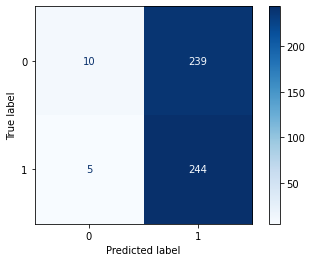

              precision    recall  f1-score   support

         0.0       0.67      0.04      0.08       249
         1.0       0.51      0.98      0.67       249

    accuracy                           0.51       498
   macro avg       0.59      0.51      0.37       498
weighted avg       0.59      0.51      0.37       498

test iteration = 12
start_date:600 , end_ft_day: 780        start_lbl_date:781 , end_lbl_day: 871

        Train results:
          True positive: 245,
          True negative: 12,
          False positive: 237,
          False negative: 4

          
        


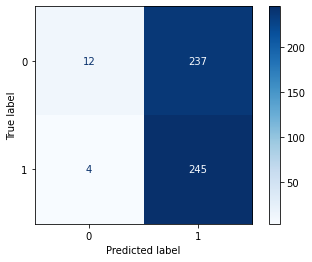

              precision    recall  f1-score   support

         0.0       0.75      0.05      0.09       249
         1.0       0.51      0.98      0.67       249

    accuracy                           0.52       498
   macro avg       0.63      0.52      0.38       498
weighted avg       0.63      0.52      0.38       498



In [ ]:
for i in range(0,12):
  print(f'test iteration = {i+1}')
  all_features_test_df,all_labelling_test_df = get_features_labels_from_full_dataframe(all_df,start_train_features_day = 270+30*i)
  features_df2 = all_features_test_df.copy()
  monthly_features_df2 = Get_Monthly(all_features_test_df)

  test_df = (
            calculate_featurs(all_features_test_df)
            .reset_index()
            .pipe(lambda d:Get_all_features(d, features_df2, monthly_features_df2))
            .assign(predicted_y = lambda d:clf.predict(d.drop('stock',axis=1)))
            .pipe(lambda d:add_actual(d,all_labelling_test_df))
            )
  Confusion_and_Report(test_df)

###Picking porfolio

wanting to get the best representation of the wanted date we will take the closet thing

In [ ]:
all_features_train_df,all_labelling_train_df = get_features_labels_from_full_dataframe(all_df,start_train_features_day = int(all_df['t0'].max()-270-200) )
features_df = all_features_train_df.copy()
monthly_features_df = Get_Monthly(all_features_train_df)
train_df = (
            calculate_featurs(all_features_train_df)
            .reset_index()
            .pipe(lambda d:Get_all_features(d, features_df, monthly_features_df))
            .pipe(lambda d:add_actual(d,all_labelling_train_df))
            .rename(columns = {'actual_y':'target'})
            )

start_date:1051 , end_ft_day: 1231        start_lbl_date:1232 , end_lbl_day: 1322


In [ ]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(train_df.drop(['stock', 'target'],axis=1), train_df['target'])

RandomForestClassifier(max_depth=3, random_state=0)

In [ ]:
all_features_test_df,all_labelling_train_df = get_features_labels_from_full_dataframe(all_df,start_train_features_day = 1320  )
features_df2 = all_features_test_df.copy()
monthly_features_df2 = Get_Monthly(all_features_test_df)

test_df = (
          calculate_featurs(all_features_test_df)
          .reset_index()
          .pipe(lambda d:Get_all_features(d, features_df2, monthly_features_df2))
          )

start_date:1320 , end_ft_day: 1500        start_lbl_date:1501 , end_lbl_day: 1591


In [ ]:
all_df.sort_values('t0',ascending=False)

,Date,Open,High,Low,Close,Volume,stock,Adj Close,dt,t0
521660,2022-08-31,157.454675,158.699101,155.513375,155.831940,2149000.0,ZTS,NaN,2022-08-31,1521.0
143349,2022-08-31,273.049648,274.836222,268.009236,269.396606,3120200.0,DHR,NaN,2022-08-31,1521.0
235223,2022-08-31,201.868954,201.868954,196.237156,196.883911,1869300.0,HCA,NaN,2022-08-31,1521.0
278273,2022-08-31,28.759241,29.106933,28.183063,28.232733,5695500.0,JNPR,NaN,2022-08-31,1521.0
347463,2022-08-31,41.040433,41.323265,40.143159,40.338219,13755400.0,NEM,NaN,2022-08-31,1521.0
...,...,...,...,...,...,...,...,...,...,...
396711,2018-07-02,73.831568,75.000343,73.545337,75.000343,1389700.0,PRU,NaN,2018-07-02,0.0
199871,2018-07-02,106.294437,106.950211,103.948779,104.873589,461700.0,FRT,NaN,2018-07-02,0.0
9450,2018-07-02,127.033321,127.183883,125.546559,126.751022,662500.0,AAP,NaN,2018-07-02,0.0
51450,2018-07-02,60.457115,61.061408,60.429225,60.670944,1026200.0,AJG,NaN,2018-07-02,0.0


In [ ]:
X = test_df.drop(['stock'],axis=1).fillna(-999)

y_pred_prob = clf.predict_proba(X)
y_pred = clf.predict(X)


Best_predictions = (
                    test_df
                    .assign(certainty = y_pred_prob.max(axis=1),
                            target = y_pred )
                    .pipe(lambda d:d.sort_values(by='certainty',ascending=False))
                    )
stocks_to_long = (
                  Best_predictions
                 .query('target == 1')
                 .head(50)
                 )

stocks_to_short = (
                  Best_predictions
                 .query('target == 0')
                 .head(50)
                 ) 

long = list(stocks_to_long['stock'].values)
long_df_features = features_df.query('stock in(@long)')


In [ ]:
def std_of_portfolio(features_df):
  return  (
            features_df
            .groupby('stock')
            .apply(lambda x: calculate_returns(x))
            .reset_index()
            [0]
            .std()
            )
  
def get_sharp(features_df,rf=0):
  sumOpen = features_df.groupby('stock')['Open'].first().sum()
  sumClose = features_df.groupby('stock')['Close'].last().sum()
  IndexReturn = (100*(sumClose-sumOpen)/sumOpen).min()
  return (IndexReturn - rf)/std_of_portfolio(features_df)

def get_max_drawdown(features_df):
  
  # group the data by date and calculate the daily returns of the index
  index_returns = features_df.groupby('dt').apply(lambda x: (x['Close'].sum() - x['Open'].sum()) / x['Open'].sum())

  # calculate the cumulative returns of the index
  cumulative_returns = (1 + index_returns).cumprod()
  # calculate the running maximum of the cumulative returns
  running_max = cumulative_returns.cummax()

  # calculate the drawdown from the running maximum
  drawdown = cumulative_returns / running_max - 1

  # find the maximum drawdown of the index
  max_drawdown = drawdown.min()
  return max_drawdown


In [ ]:
print(f'''
      sharp of portfolio is : {get_sharp(long_df_features)}
      Volatility of portfolio is :{std_of_portfolio(long_df_features)}
      The maximum drawdown of the portfolio is : {get_max_drawdown(long_df_features):.2%}
      \n
      sharp of the S&P 500 index is : {get_sharp(features_df2)}
      Volatility of the S&P 500 index is:{std_of_portfolio(features_df2)}
      The maximum drawdown of the S&P 500 index is {get_max_drawdown(features_df2):.2%}")
      '''
      )


      sharp of portfolio is : 0.1216530727344285
      Volatility of portfolio is :14.269580574547849
      The maximum drawdown of the portfolio is : -9.13%
      

      sharp of the S&P 500 index is : -0.4164664950184792
      Volatility of the S&P 500 index is:17.924643548301763
      The maximum drawdown of the S&P 500 index is -13.41%")
      


We picked training the model on the most recent time we could in respect to the required date(01/06/2022), we wanted to both the train and the test to have the same length of time for calculating features(6 months) and for the train we still had to have a labelling period so we could calibrate our model.

this is all under the assumption of still using a basic RF model, in the real world we would try to use a more complex models such as LTSM or Transfomer based NN, which if was the case we would take a much larger period of training time

##Third Assignment

In [ ]:
!pip3 install backtesting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###3.1+3.2

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA
from statistics import mean, stdev

class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()
            
def calculate_portfolio_stats(all_data, portfolio_stocks):
    '''
        all_data: pd.Dataframe, needs to include all your required stocks OHLCV data.
        portfolio_stocks: List[str], list of your required portfolio stock tickers for an example: ['AAPL','TSLA'].
        must be consistentr with the stocks column uin your all_data df
    '''
    assert len(portfolio_stocks) > 1, 'portfolio must include more than one stock'
    returns = []
    sharpes = []
    for stock in portfolio_stocks:
        if stock == 'A': continue
        stock_data = all_data[all_data['stock'] == stock][['Open', 'High', 'Low', 'Close', 'Volume']]
        bt = Backtest(stock_data, SmaCross,
                    cash=10000, commission=.002,
                    exclusive_orders=True)
        output = bt.run()
        sharpes.append(output.loc['Sharpe Ratio'])
        returns.append(output.loc['Return [%]'])
    mean_returns = mean(returns)
    returns_std = stdev(returns)
    mean_sharpes = mean(sharpes)
    sharpes_std = stdev(sharpes)
    return mean_returns, returns_std, mean_sharpes, sharpes_std



In [ ]:
results_df = pd.DataFrame([calculate_portfolio_stats(all_df.set_index('dt'),stocks_to_short['stock'].values.tolist()), calculate_portfolio_stats(all_df.set_index('dt'),stocks_to_long['stock'].values.tolist()), calculate_portfolio_stats(all_df.set_index('dt'),all_df.stock.unique().tolist())], 
                  columns=['mean_returns', 'returns_std', 'mean_sharpes', 'sharpes_std'],
                  index=['short_portfolio', 'long_portfolio', 'entire_index'])
results_df

,mean_returns,returns_std,mean_sharpes,sharpes_std
short_portfolio,1.711490,78.315160,0.105826,0.178389
long_portfolio,-34.221876,41.924843,0.036592,0.130008
entire_index,-8.187407,78.901263,0.075192,0.159081
